# Classification using Scattering Transform 

We use Scattering transform to create feature vectors and classify videos from flat and ridged surface (without electric field) using SVM

In [1]:
import numpy as np

# Import Kymatio

Here we import the Scattering2D filters with parameters J=4, L=12 from the Kymatio package

In [2]:
from kymatio.numpy import Scattering2D
S = Scattering2D(J=4, L=12, max_order=1, shape=(512, 512))

## File Upload

We read the tiff image files from the corresponding folders for videos from flat and ridged surface without any eleectric field

In [3]:
import numpy as np 
from skimage import io
import os
import glob
img_dir = "flat cell videos/nofield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_nofield.append(img)
    
    
img_dir = "ridged cell videos/nofield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_nofield.append(img)


## Displaying images

Here we display an image frame from a video of cell motion on flat surface and the corresponding image after passing the image through one of the scattering transform filters

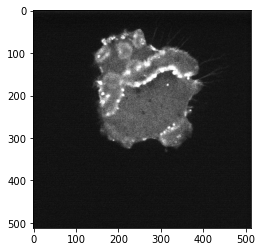

In [4]:
import matplotlib.pyplot as plt
plt.imshow(flat_nofield[7][:,:,0], cmap='gray')

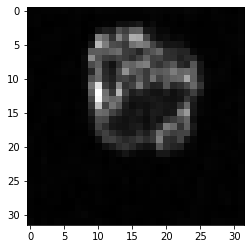

In [5]:
im = S(flat_nofield[7][:,:,0])
plt.imshow(im[36], cmap='gray')
plt.savefig('flat_wavelet3.png')

## Creating the feature vectors

After we pass the image frames through the scattering transform, we produce the feature vectors here which we use as an input to our classifier

In [149]:
def coding(input_list):
    X = []
    for i in range(len(input_list)):
        Y = []
        input = input_list[i] / 255.
        for j in range(input.shape[2]):
            scatt = S(input[:,:,j])
            code_scatt = (np.sum(np.abs(scatt), axis=(1,2)))/(scatt.shape[1]*scatt.shape[2])
            Y.append(code_scatt)
        Y = np.asarray(Y)
        X.append(Y)
        print('done for %i th sample' % i)
    return(X)

In [ ]:
flat = coding(flat_nofield)
ridged = coding(ridged_nofield)

In [6]:
flat = np.load('flat_wavelet_new.npy', allow_pickle=True)
ridged = np.load('ridged_wavelet_new.npy', allow_pickle=True)

## Data splits and classification using SVM

We create 3 different splits of the dataset. Then use two of the splits as our training data and the remaining split as the test data. We fit a SVM classifer to the training data, then predict on the test data and display the classification results using a confusion matrix.

In [7]:
flat_set1 = np.concatenate((flat[0],flat[1],flat[2],flat[3]),axis=0)
flat_set2 = np.concatenate((flat[4],flat[5],flat[6],flat[7]),axis=0)
flat_set3 = np.concatenate((flat[8],flat[9],flat[10],flat[11]),axis=0)
ridged_set1 = ridged[0]
ridged_set2 = np.concatenate((ridged[2],ridged[3]),axis=0)
ridged_set3 = np.concatenate((ridged[4],ridged[5]),axis=0)

In [8]:
flat_set1_labels = np.zeros((flat_set1.shape[0],))
flat_set2_labels = np.zeros((flat_set2.shape[0],))
flat_set3_labels = np.zeros((flat_set3.shape[0],))
ridged_set1_labels = np.ones((ridged_set1.shape[0],))
ridged_set2_labels = np.ones((ridged_set2.shape[0],))
ridged_set3_labels = np.ones((ridged_set3.shape[0],))

In [9]:
X_test = np.concatenate((flat_set2,ridged_set2),axis=0)
y_test = np.concatenate((flat_set2_labels,ridged_set2_labels),axis=0)
X_train = np.concatenate((flat_set1,flat_set3,ridged_set1,ridged_set3),axis=0)
y_train = np.concatenate((flat_set1_labels,flat_set3_labels,ridged_set1_labels,ridged_set3_labels),axis=0)

In [10]:
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.svm import LinearSVC

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5]}               
clf = GridSearchCV(
    LinearSVC(class_weight=None, dual=False, max_iter=1000000000, penalty='l1'), param_grid
)
clf = clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 2.277s
Best estimator found by grid search:
LinearSVC(C=10, dual=False, max_iter=1000000000, penalty='l1')


In [17]:
from sklearn import svm, metrics
from sklearn.svm import LinearSVC

classifier = LinearSVC(C=5000, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000000000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

classifier.score(X_test,y_test)

Classification report for classifier LinearSVC(C=5000, dual=False, max_iter=1000000000, penalty='l1'):
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94       284
         1.0       0.82      1.00      0.90       153

    accuracy                           0.92       437
   macro avg       0.91      0.94      0.92       437
weighted avg       0.94      0.92      0.92       437




0.9221967963386728

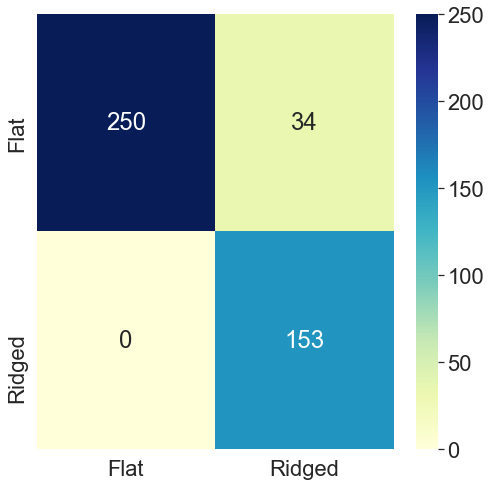

In [18]:
import seaborn as sn
import pandas as pd


a = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
df_cm = pd.DataFrame(a, range(2), range(2))
plt.figure(figsize=(8,8))
df_cm = df_cm.rename(index={0: "Flat", 1: "Ridged"}, columns={0: "Flat", 1: "Ridged"})
sn.set(font_scale=2.0) # for label size
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt='.0f') # font size
plt.show()